In [142]:
import numpy as np
import matplotlib.pyplot as plt

start_health = 4

def start_state():
  return np.array([
    [start_health, start_health, start_health, 0],
    [start_health, start_health, start_health, 0],
  ])

def end_state():
  return np.zeros((2,4))

# type advantage, if attacker is 1 and target is 0, double damage
def assign_damage(state, action, target_player):
  active_index = state[target_player][3]
  
  # opp_index refers to index of *the attacker*
  opp_index = state[(target_player*-1)+1][3]
  modifier = 1
  
  # type modifiers
  if active_index == 0 and opp_index == 1:
    modifier = 2
  if active_index == 1 and opp_index == 2:
    modifier = 2
  if active_index == 2 and opp_index == 0:
    modifier = 2
  if active_index == 1 and opp_index == 0:
    modifier = 0.5
  if active_index == 2 and opp_index == 1:
    modifier = 0.5
  if active_index == 0 and opp_index == 2:
    modifier = 0.5
  
  updated_health = 0
  
  if action == 3:
    damage = int(2 * modifier)
    updated_health = max(state[target_player][active_index]-damage, 0)
    state[target_player][active_index] = updated_health
    
  if action == 4:
    if np.random.random() > 0.5:
      damage = int(4 * modifier)
      updated_health = max(state[target_player][active_index]-damage, 0)
      state[target_player][active_index] = updated_health
  
  return state

# action: 0 = swap to 0, 1 = swap to 1, 2 = swap to 2, 3 = weak attack, 4 = strong attack
def step(state, action, opp):
  
  # get opponent's move
  opp_action = opp(state)
  
  if opp_action < 0 or opp_action > 4 or action < 0 or action > 4:
    raise TypeErro
  
  # if player action is swap, see if swap is legal and apply it if so
  if action in [0,1,2]:
    if state[0][action] > 0:
      state[0][3] = action
  
  # if opponent action is swap, see if swap is legal and apply it if so
  if opp_action in [0,1,2]:
    if state[1][opp_action] > 0:
      state[1][3] = opp_action
  
  # figure out who goes first, assume 50/50
  player_goes_first = np.random.random() > 0.5
  
  # get active pokemon indices
  opp_active_index = state[1][3]
  player_active_index = state[0][3]
  
  # handle the damage calculation
  if player_goes_first:
    state = assign_damage(state, action, 1)
    # only let opponent move if they survived
    if state[1][opp_active_index] > 0:
      state = assign_damage(state, opp_action, 0)
  else:
    state = assign_damage(state, opp_action, 0)
    # only let player move if they survived
    if state[0][player_active_index] > 0:
      state = assign_damage(state, action, 1)
      
  # check if all fainted on either side, opponent-first
  if np.sum(state[1][0:3]) == 0:
    return 1, end_state()
  if np.sum(state[0][0:3]) == 0:
    return -1, end_state()
  
  # swap out fainted pokemon on either side, opponent-first
  indices = np.array([0,1,2])
  np.random.shuffle(indices)
  if state[1][opp_active_index] == 0:
    for i in indices:
      if state[1][i] > 0:
        state[1][3] = i
        break
        
  np.random.shuffle(indices)
  if state[0][player_active_index] == 0:
    for i in indices:
      if state[0][i] > 0:
        state[0][3] = i
        break
  return 0, state


def run_episode(agent, opponent):
  num_trials = 0
  reward = 0
  state = start_state()
  action = agent(state)
  state_action_pairs = []
  state_action_pairs.append((np.copy(state),action))
  
  while reward == 0:
    reward, state = step(state, action, opponent)
    action = agent(state)
    state_action_pairs.append((np.copy(state),action))
    num_trials += 1
    if num_trials > 500:
      raise IndexError
      
  return reward, state_action_pairs


def loss_rate(n, agent, opponent):
  total = 0
  for i in range(0, n):
    reward, s = run_episode(agent, opponent)
    if reward == 1:
      total += reward
  return 1-(total/n)


class MCAgent(object):
  
  def __init__(self, discount, epsilon):
    self.discount = discount
    self.policy = {}
    self.all_rewards_seen = {}
    self.min_epsilon = epsilon
    self.epsilon = 1
    self.epsilon_decay = 0.99
    self.epsilon_temp = 0
    self.min_epsilon_temp = 0
    
  def __call__(self, state):
    # use the string version of arrays as keys
    try:
      action_values = self.policy[str(state)]
    except KeyError:
      self.policy[str(state)] = {0:0, 1:0, 2:0, 3:0, 4:0}
      action_values = self.policy[str(state)]  
    best_action = max(action_values, key=action_values.get)
    
    self.epsilon = self.epsilon*self.epsilon_decay
    
    if np.random.random() > max(self.epsilon, self.min_epsilon):
      return best_action
    else:
      return int(np.random.random()*5)
    
  def update(self, reward, states):
    for state,action in reversed(states):
      reward = self.discount*reward
      
      try:
        action_values = self.policy[str(state)]
      except KeyError:
        self.policy[str(state)] = {0:0, 1:0, 2:0, 3:0, 4:0}
        action_values = self.policy[str(state)]
      
      try:
        rewards_count = self.all_rewards_seen[str(state)]
      except KeyError:
        self.all_rewards_seen[str(state)] = 0
        rewards_count = self.all_rewards_seen[str(state)] 
      
      rewards_count += 1
      p1 = (rewards_count/(rewards_count+1))
      p2 = 1-p1
      action_values[action] = p1*action_values[action]+p2*reward
      
  def eval_mode(self):
    self.epsilon_temp = self.epsilon
    self.min_epsilon_temp = self.min_epsilon
    self.epsilon = 0
    self.min_epsilon = 0
    
  def train_mode(self):
    self.epsilon = self.epsilon_temp
    self.min_epsilon = self.min_epsilon_temp

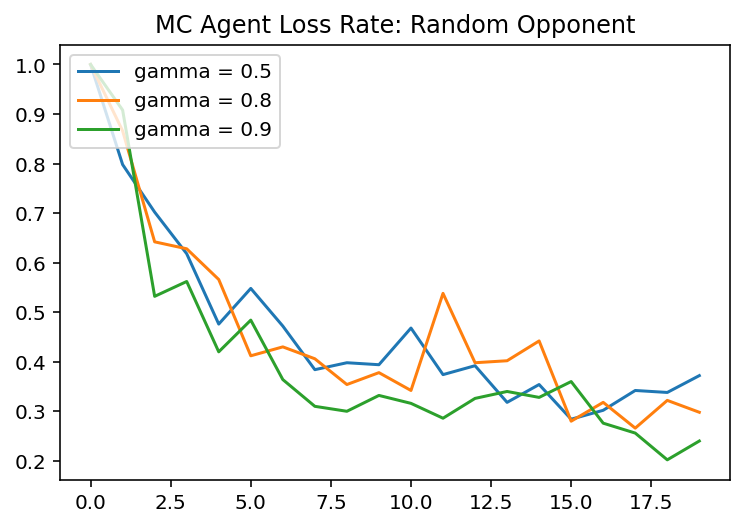

In [157]:
opponent = lambda x: int(np.random.random()*5)

num_iters = 10000
chunk = 500

for discount in [0.5, 0.8, 0.9]:
  agent = MCAgent(discount, 0.05)
  loss_rates = []
  for i in range(num_iters):
    agent.train_mode()
    reward, states = run_episode(agent, opponent)
    agent.update(reward, states)
    if i % chunk == 0:
      agent.eval_mode()
      loss_rates.append(loss_rate(500, agent, opponent))
  plt.plot(loss_rates, label=("gamma = " + str(discount)))
  
plt.legend(loc="upper left")
plt.title("MC Agent Loss Rate: Random Opponent")
plt.show()

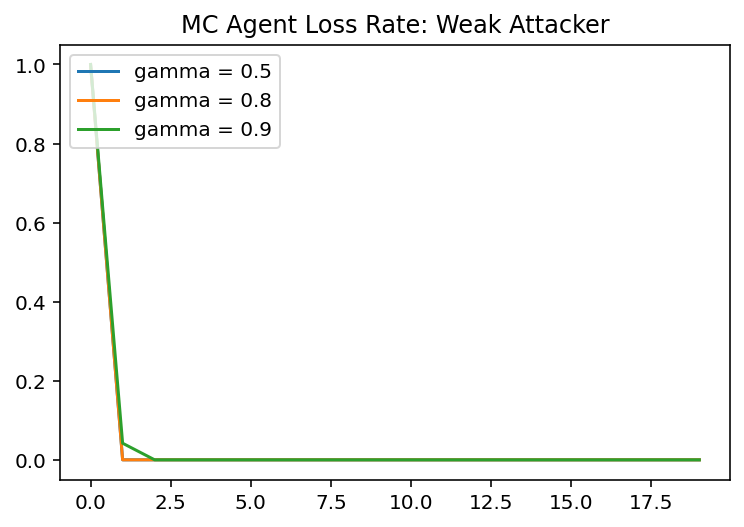

In [158]:
opponent = lambda x: 3

num_iters = 10000
chunk = 500

for discount in [0.5, 0.8, 0.9]:
  agent = MCAgent(discount, 0.05)
  loss_rates = []
  for i in range(num_iters):
    agent.train_mode()
    reward, states = run_episode(agent, opponent)
    agent.update(reward, states)
    if i % chunk == 0:
      agent.eval_mode()
      loss_rates.append(loss_rate(500, agent, opponent))
  plt.plot(loss_rates, label=("gamma = " + str(discount)))
  
plt.legend(loc="upper left")
plt.title("MC Agent Loss Rate: Weak Attacker")
plt.show()

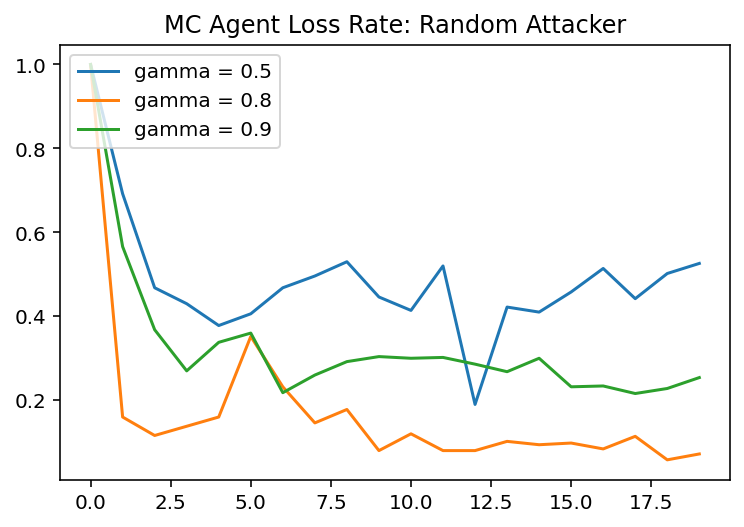

In [162]:
opponent = lambda x: 3+int(np.random.random()*2)

num_iters = 10000
chunk = 500

for discount in [0.5, 0.8, 0.9]:
  agent = MCAgent(discount, 0.05)
  loss_rates = []
  for i in range(num_iters):
    agent.train_mode()
    reward, states = run_episode(agent, opponent)
    agent.update(reward, states)
    if i % chunk == 0:
      agent.eval_mode()
      loss_rates.append(loss_rate(500, agent, opponent))
  plt.plot(loss_rates, label=("gamma = " + str(discount)))
  
plt.legend(loc="upper left")
plt.title("MC Agent Loss Rate: Random Attacker")
plt.show()

In [129]:
class TDAgent(object):
  
  def __init__(self, discount, epsilon, alpha):
    self.discount = discount
    self.policy = {}
    self.all_rewards_seen = {}
    self.min_epsilon = epsilon
    self.epsilon = 1
    self.epsilon_decay = 0.99
    self.epsilon_temp = 0
    self.min_epsilon_temp = 0
    self.alpha = alpha
    
  def __call__(self, state):
    # use the string version of arrays as keys
    try:
      action_values = self.policy[str(state)]
    except KeyError:
      self.policy[str(state)] = {0:0, 1:0, 2:0, 3:0, 4:0}
      action_values = self.policy[str(state)]  
    best_action = max(action_values, key=action_values.get)
    self.epsilon = self.epsilon*self.epsilon_decay
    if np.random.random() > max(self.epsilon, self.min_epsilon):
      return best_action
    else:
      return int(np.random.random()*5)
    
  # We update prev_state with the value from state
  def update(self, action, reward, state, prev_state):
    try:
      action_values = self.policy[str(prev_state)]
    except KeyError:
      self.policy[str(prev_state)] = {0:0, 1:0, 2:0, 3:0, 4:0}
      action_values = self.policy[str(prev_state)]
    try:
      future_values = self.policy[str(state)]
    except KeyError:
      self.policy[str(state)] = {0:0, 1:0, 2:0, 3:0, 4:0}
      future_values = self.policy[str(state)]
    best_future_value = max(future_values.values())
    td_delta = self.alpha*(reward + self.discount*best_future_value-action_values[action])
    action_values[action] = action_values[action] + td_delta
    
  
  def eval_mode(self):
    self.epsilon_temp = self.epsilon
    self.min_epsilon_temp = self.min_epsilon
    self.epsilon = 0
    self.min_epsilon = 0
    
  def train_mode(self):
    self.epsilon = self.epsilon_temp
    self.min_epsilon = self.min_epsilon_temp

In [130]:
def run_td_once(agent, opponent):
  num_trials = 0
  reward = 0
  state = start_state()
  action = agent(state)
  prev_state = None
  prev_action = None
  while reward == 0:
    prev_state = np.copy(state)
    prev_action = action
    reward, state = step(state, action, opponent)
    action = agent(state)
    agent.update(prev_action, reward, state, prev_state)
    
def train_td_agent(n, agent, opponent):
  for i in range(n):
    run_td_once(agent, opponent)

KeyboardInterrupt: 

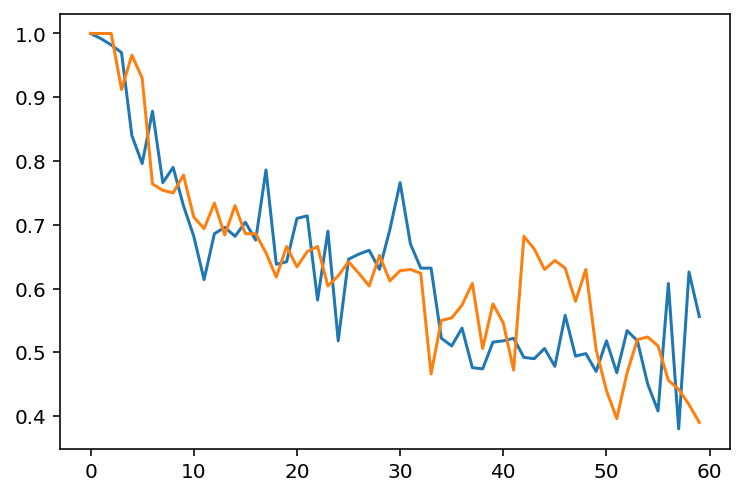

In [168]:
opponent = lambda x: int(np.random.random()*5)
num_iters = 30000
chunk = 500

for discount in [0.5, 0.8, 0.9]:
  agent = TDAgent(discount, 0.05, 0.9)
  loss_rates = []
  for i in range(num_iters):
    agent.train_mode()
    train_td_agent(1, agent, opponent)
    if i % chunk == 0:
      agent.eval_mode()
      loss_rates.append(loss_rate(500, agent, opponent))
  plt.plot(loss_rates, label=("gamma = " + str(discount)))
  
plt.legend(loc="upper left")
plt.title("TD(0) Agent Loss Rate: Random Opponent")
plt.show()

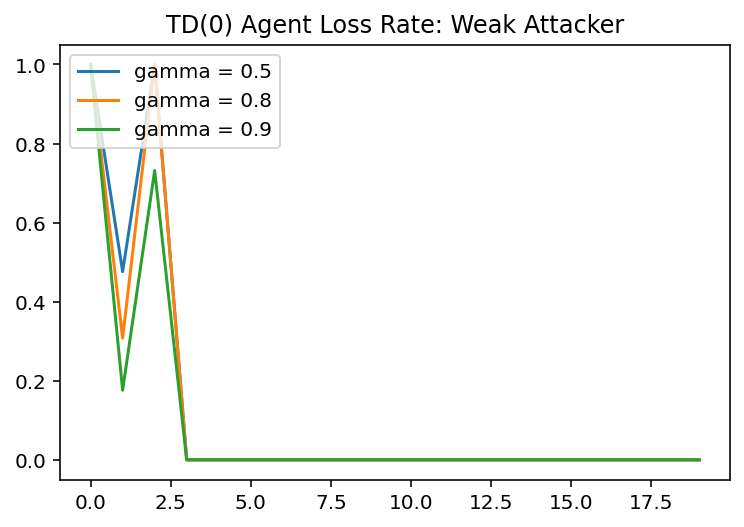

In [166]:
opponent = lambda x: 3
num_iters = 10000
chunk = 500

for discount in [0.5, 0.8, 0.9]:
  agent = TDAgent(discount, 0.05, 0.9)
  loss_rates = []
  for i in range(num_iters):
    agent.train_mode()
    train_td_agent(1, agent, opponent)
    if i % chunk == 0:
      agent.eval_mode()
      loss_rates.append(loss_rate(500, agent, opponent))
  plt.plot(loss_rates, label=("gamma = " + str(discount)))
  
plt.legend(loc="upper left")
plt.title("TD(0) Agent Loss Rate: Weak Attacker")
plt.show()

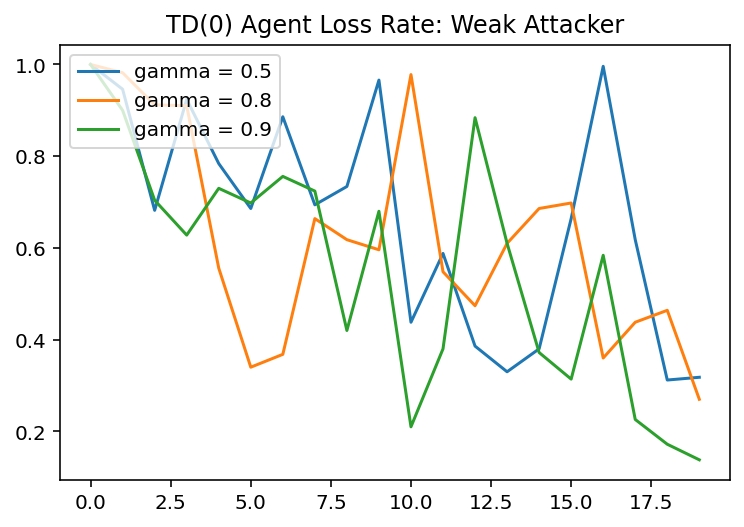

In [167]:
opponent = lambda x: 3+int(np.random.random()*2)
num_iters = 10000
chunk = 500

for discount in [0.5, 0.8, 0.9]:
  agent = TDAgent(discount, 0.05, 0.9)
  loss_rates = []
  for i in range(num_iters):
    agent.train_mode()
    train_td_agent(1, agent, opponent)
    if i % chunk == 0:
      agent.eval_mode()
      loss_rates.append(loss_rate(500, agent, opponent))
  plt.plot(loss_rates, label=("gamma = " + str(discount)))
  
plt.legend(loc="upper left")
plt.title("TD(0) Agent Loss Rate: Weak Attacker")
plt.show()

Submit your nal project in .pdf format, including:•Source code, executable and README . 

We recommend you using a github repository to hold the source code,executable and a README le that provides a brief guide to run your code. In this case, you just need to providethe github link within your nal report. If you want to keep your repository private for any reason, please zip yourproject folder including the source code, executable and the README le, and include that with your submission.

•A 5-minute mp4 YouTube video summarizing your project and the main results (make sure to choose unlist optionso that only people with the URL can access your video). e URL should be included in your nal report PDF, at thebeginning of your report, along with your github link. e detail instructions for uploading the video are on Piazza.

•A detailed wrien report describing your project, including its merits, and its deciencies. As much as possible,you should relate your approach to the readings from throughout the course. View this report as a term paper. ereport should be roughly in the style of a conference paper, including introduction, motivation, related work, etc. Allwriting should be your own – all quotes must be clearly aributed. Remember to proofread and spell-check!